 # Lab 4

For this lab you need subsample with timeseries, spatial fields or temporal spatial fields.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from scipy.ndimage import gaussian_filter1d
import scipy.signal
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (12,6)

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data.csv', low_memory=False)

In [4]:
data.head()

,station_id,product_id,date,hour,price,volume,discount_bonusy_rub,month_num,weekday,quarter_num,...,year,region_name,station_size,location,station_type,n_competitors,trk,year_month,closeness_mean,closeness_sum
0,15690,Diesel winter,2016-01-11,6,35.9,0.027767,55.011,1,0,1,...,2016,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,19.0,2016-01,349.304372,944105.74229
1,15690,Diesel winter,2016-01-11,7,35.9,0.047328,-0.001,1,0,1,...,2016,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,19.0,2016-01,349.304372,944105.74229
2,15690,Diesel winter,2016-01-11,9,35.9,0.046284,99.996,1,0,1,...,2016,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,19.0,2016-01,349.304372,944105.74229
3,15690,Diesel winter,2016-01-11,11,35.9,0.014315,0.004,1,0,1,...,2016,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,19.0,2016-01,349.304372,944105.74229
4,15690,Diesel winter,2016-01-11,12,35.9,0.019987,29.401,1,0,1,...,2016,1,Автомат,№1 Столица региона на городской магистрали,автоматическая,19,19.0,2016-01,349.304372,944105.74229


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574997 entries, 0 to 574996
Data columns (total 55 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   station_id                                      574997 non-null  int64  
 1   product_id                                      574997 non-null  object 
 2   date                                            574997 non-null  object 
 3   hour                                            574997 non-null  int64  
 4   price                                           574997 non-null  float64
 5   volume                                          574997 non-null  float64
 6   discount_bonusy_rub                             574997 non-null  float64
 7   month_num                                       574997 non-null  int64  
 8   weekday                                         574997 non-null  int64  
 9   quarter_num               

In [6]:
data['cost'] = data['cost'].fillna(method='ffill').fillna(method='bfill')
data['profit'] = data['cost'] * data['volume']
data = data.loc[(data['station_id']==58810) & (data['product_id']=='Petrol 92')]
data = data[data['year_month']>'2022-01']
data['month'] = data['month_num']
data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']], format = '%Y/%M/%D %H')
dates = data['date'].values
data = data.reset_index(drop=True)

### Step 1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [9]:
target_variables = ['volume', 'profit']
predictors = ['price', 'discount', 'discount_bonusy_rub', 'big_competitor_mean_price_relative', 'big_competitor_min_price_relative']

chosen_variables = ['date','volume', 'profit', 
                    'price', 'discount', 'discount_bonusy_rub', 'big_competitor_mean_price_relative', 'big_competitor_min_price_relative']

In [10]:
data[chosen_variables]

,date,volume,profit,price,discount,discount_bonusy_rub,big_competitor_mean_price_relative,big_competitor_min_price_relative
0,2022-02-01 00:00:00,0.120867,3.955154,47.45,0.00,127.54,1.000422,1.007431
1,2022-02-01 01:00:00,0.081125,2.654683,47.45,0.00,113.86,1.000422,1.007431
2,2022-02-01 02:00:00,0.042022,1.375100,47.45,0.02,0.00,1.000422,1.007431
3,2022-02-01 03:00:00,0.033318,1.090289,47.45,0.00,0.00,1.000422,1.007431
4,2022-02-01 04:00:00,0.013990,0.457787,47.45,0.00,42.14,1.000422,1.007431
...,...,...,...,...,...,...,...,...
661,2022-02-28 19:00:00,0.182417,6.037795,47.70,0.00,350.56,1.001470,1.008457
662,2022-02-28 20:00:00,0.189997,6.288682,47.70,0.01,129.96,1.001470,1.008457
663,2022-02-28 21:00:00,0.217205,7.189235,47.70,0.01,218.67,1.001470,1.008457
664,2022-02-28 22:00:00,0.229140,7.584272,47.70,1.95,266.96,1.001470,1.008457


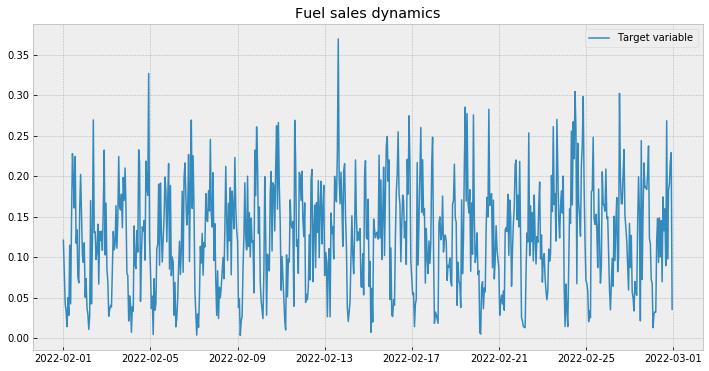

In [7]:
plt.plot(dates, data['volume'].values, label='Target variable', linewidth=1.5)
plt.title('Fuel sales dynamics')
plt.legend()
plt.show()

### Step 2

 Analyze stationarity of a process for all chosen variables. Make them more stationary if needed.

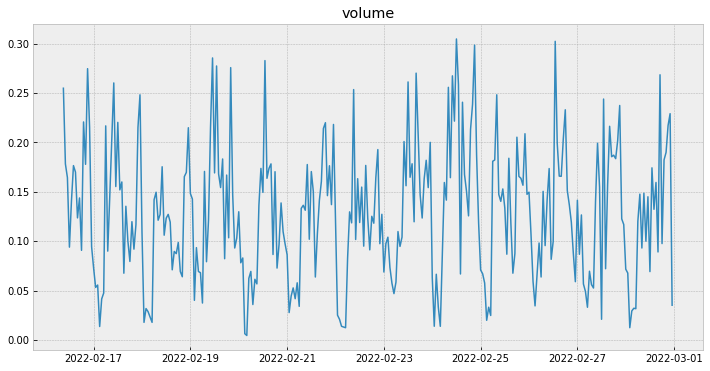

Results for variable: volume
Mathematical expectation is 0.126
Variance is 0.004
ADF Statistic:  -6.44
p-value:  0.0
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



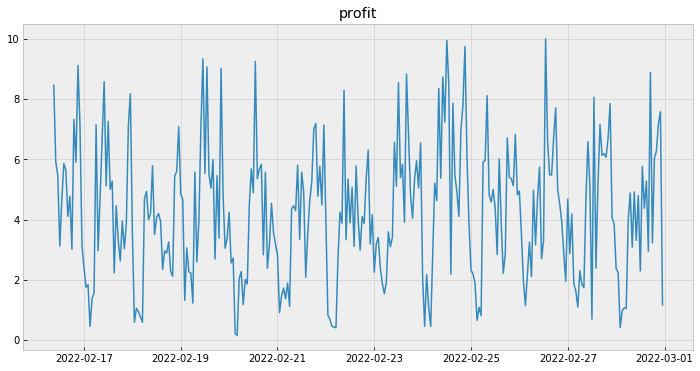

Results for variable: profit
Mathematical expectation is 4.119
Variance is 4.644
ADF Statistic:  -6.259
p-value:  0.0
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



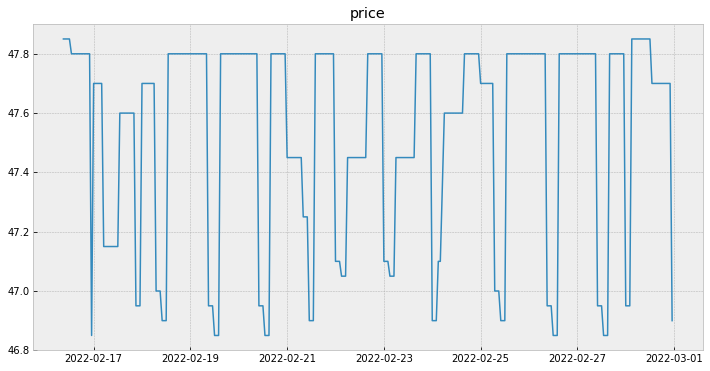

Results for variable: price
Mathematical expectation is 47.417
Variance is 0.106
ADF Statistic:  -3.153
p-value:  0.023
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



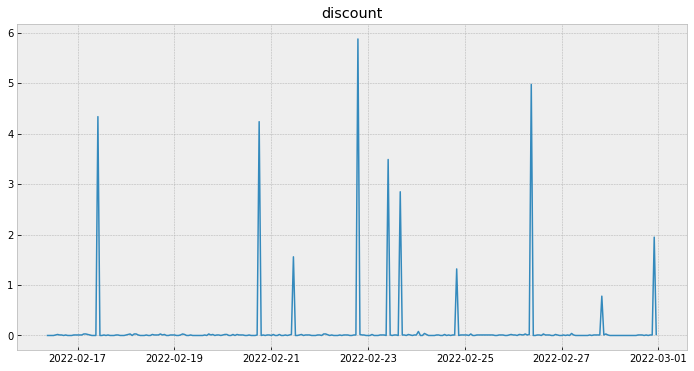

Results for variable: discount
Mathematical expectation is 0.143
Variance is 0.644
ADF Statistic:  -24.972
p-value:  0.0
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



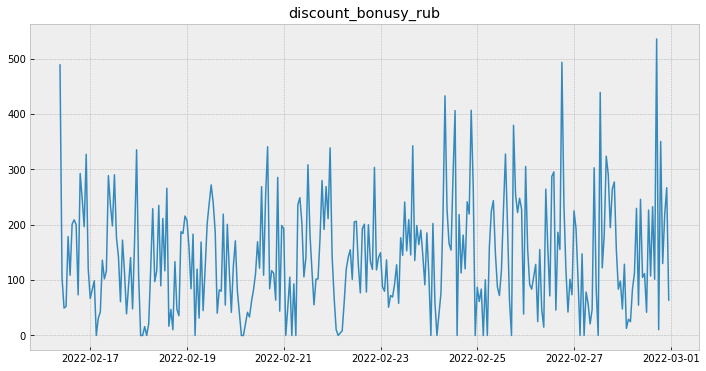

Results for variable: discount_bonusy_rub
Mathematical expectation is 131.769
Variance is 9053.575
ADF Statistic:  -5.825
p-value:  0.0
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



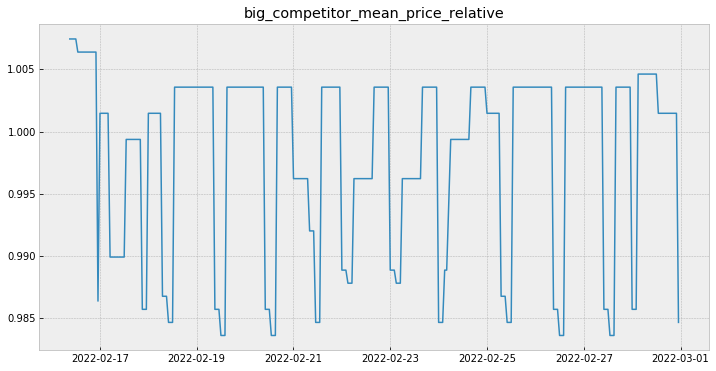

Results for variable: big_competitor_mean_price_relative
Mathematical expectation is 0.998
Variance is 0.0
ADF Statistic:  -4.705
p-value:  0.0
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



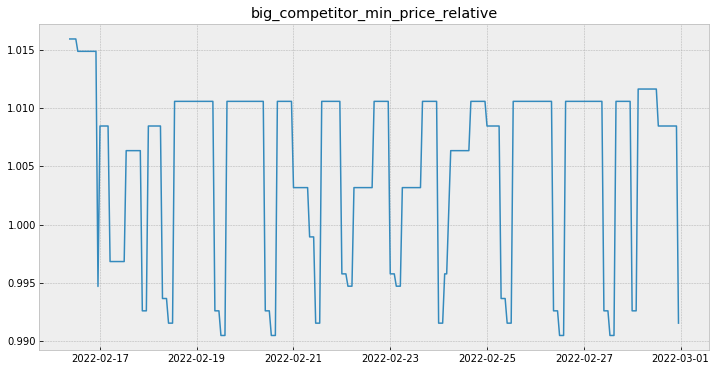

Results for variable: big_competitor_min_price_relative
Mathematical expectation is 1.005
Variance is 0.0
ADF Statistic:  -4.596
p-value:  0.0
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
The stationarity hypothesis is accepted 



In [8]:
for variable in chosen_variables:
    mean_value = round(data[variable].mean(), 3)
    var_value = round(data[variable].var(), 3)
    plt.plot(dates[-300:], data[variable].values[-300:],label=variable, linewidth=1.5)
    plt.title(variable)
    plt.show()
    print(f'Results for variable: {variable}')
    print('Mathematical expectation is', mean_value)
    print('Variance is', var_value)
    result = adfuller(data[variable])
    print('ADF Statistic: ', round(result[0],3))
    print('p-value: ', round(result[1], 3))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print('The stationarity hypothesis is accepted \n')
    else:
        print('The stationarity hypothesis is not accepted \n')

All variables are stationary.

### Step 3

Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

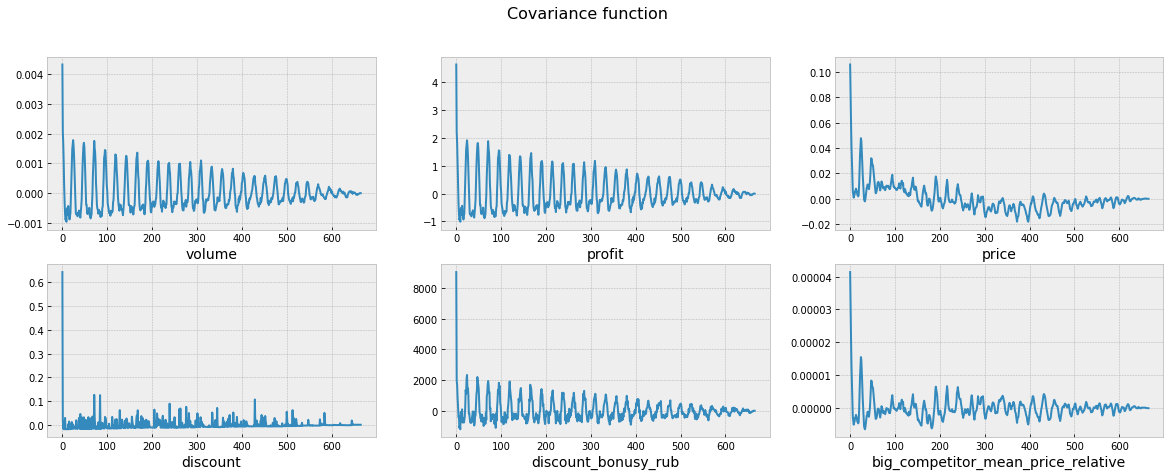

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 7))

for ax, variable in zip(axes.flat, chosen_variables[:-1]):
    ax.plot(stattools.acovf(data[variable],fft=False))
    ax.set_xlabel(variable, fontsize=14)
plt.suptitle(f'Covariance function', fontsize=16)
plt.show()

Cross-correlation matrix

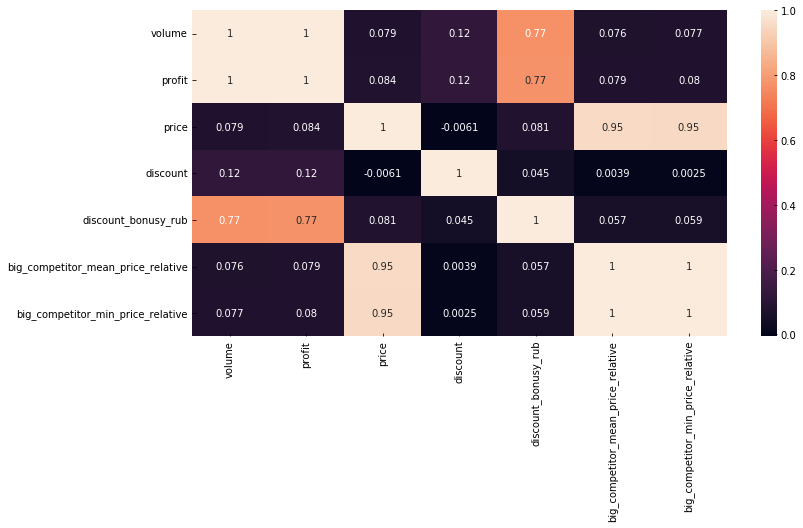

In [10]:
sns.heatmap(data[chosen_variables].corr(), annot=True)
plt.show()

### Step 4

Filter high frequencies (noise) with chosen 2 filters for target variables.

1. Rolling mean window smoothing

In [11]:
initial_volume = data['volume']
rolling_volume_5 = initial_volume.rolling(window=5).mean()
rolling_volume_15 = initial_volume.rolling(window=15).mean()

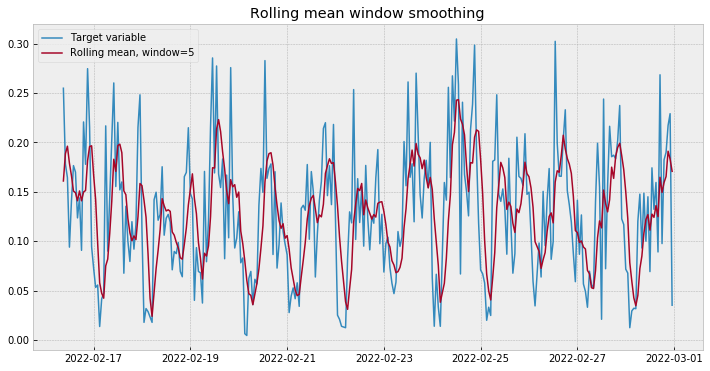

In [12]:
plt.plot(dates[-300:], initial_volume.values[-300:], label='Target variable', linewidth=1.5)
plt.plot(dates[-300:], rolling_volume_5.values[-300:], label='Rolling mean, window=5', linewidth=1.5)
plt.title('Rolling mean window smoothing')
plt.legend()
plt.show()

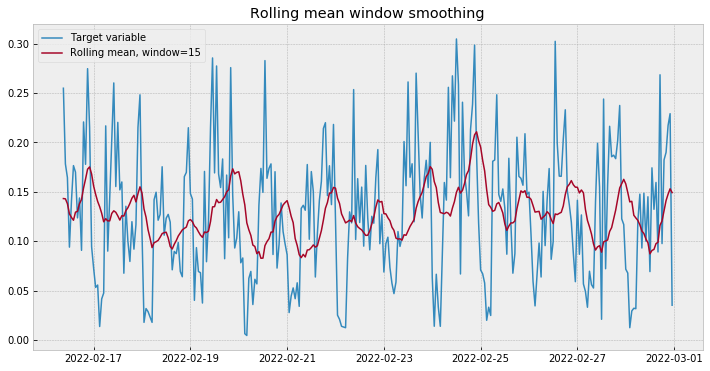

In [13]:
plt.plot(dates[-300:], initial_volume.values[-300:], label='Target variable', linewidth=1.5)
plt.plot(dates[-300:], rolling_volume_15.values[-300:], label='Rolling mean, window=15', linewidth=1.5)
plt.title('Rolling mean window smoothing')
plt.legend()
plt.show()

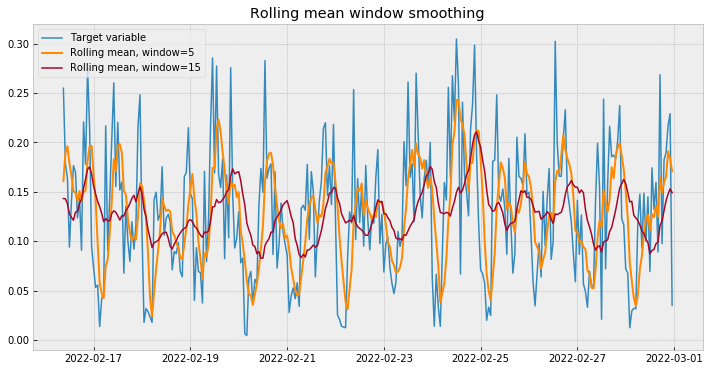

In [14]:
plt.plot(dates[-300:], initial_volume.values[-300:], label='Target variable', linewidth=1.5)
plt.plot(dates[-300:], rolling_volume_5.values[-300:], label='Rolling mean, window=5', c='#FF8900')
plt.plot(dates[-300:], rolling_volume_15.values[-300:], label='Rolling mean, window=15', linewidth=1.5)
plt.title('Rolling mean window smoothing')
plt.legend()
plt.show()

2. Gaussian filter

In [15]:
gaussian_volume_1 = gaussian_filter1d(initial_volume, 1)
gaussian_volume_5 = gaussian_filter1d(initial_volume, 5)

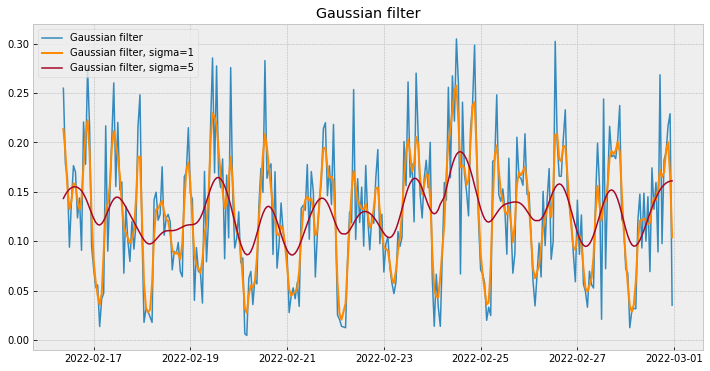

In [16]:
plt.plot(dates[-300:], initial_volume.values[-300:], label='Gaussian filter', linewidth=1.5)
plt.plot(dates[-300:], gaussian_volume_1[-300:], label='Gaussian filter, sigma=1', c='#FF8900')
plt.plot(dates[-300:], gaussian_volume_5[-300:], label='Gaussian filter, sigma=5', linewidth=1.5)
plt.title('Gaussian filter')
plt.legend()
plt.show()

### Step 5

Estimate spectral density function for with and without filtering.

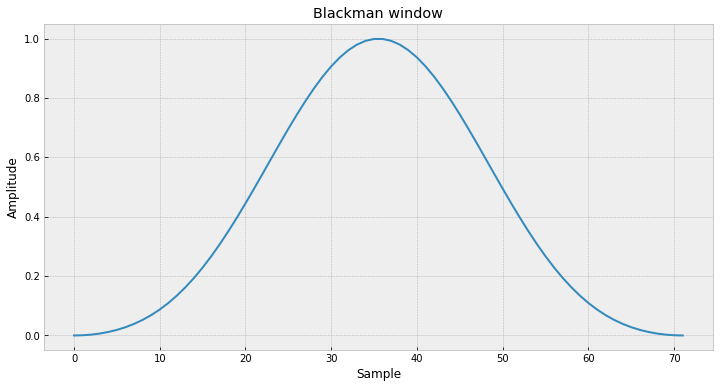

In [17]:
window_size = 72
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

plt.plot(blackman)
plt.title("Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

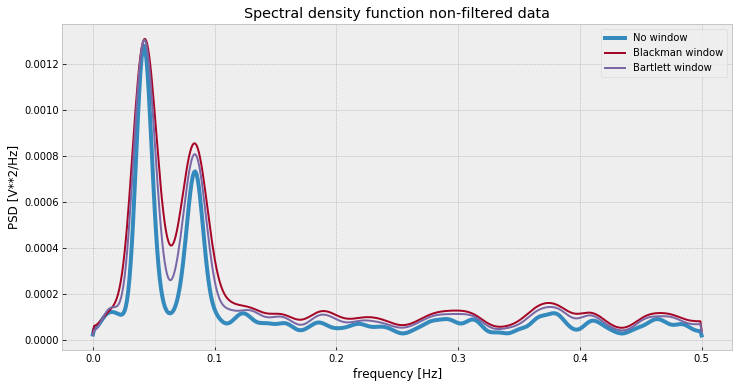

In [18]:
f, Pxx_den = signal.welch(initial_volume, fs=1, scaling='spectrum', nfft = 1000, nperseg=100,)
f_window, Pxx_den_window = signal.welch(initial_volume, fs=1, window = blackman, nfft = 1000, scaling='spectrum', )
f_window_bart, Pxx_den_window_bart = signal.welch(initial_volume, fs=1, window = bartlett, nfft = 1000, scaling='spectrum', )

plt.plot(f, Pxx_den, linewidth=4, label='No window')
plt.plot(f_window, Pxx_den_window, label='Blackman window')
plt.plot(f_window_bart, Pxx_den_window_bart, label='Bartlett window')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectral density function non-filtered data')
plt.legend()
plt.show()

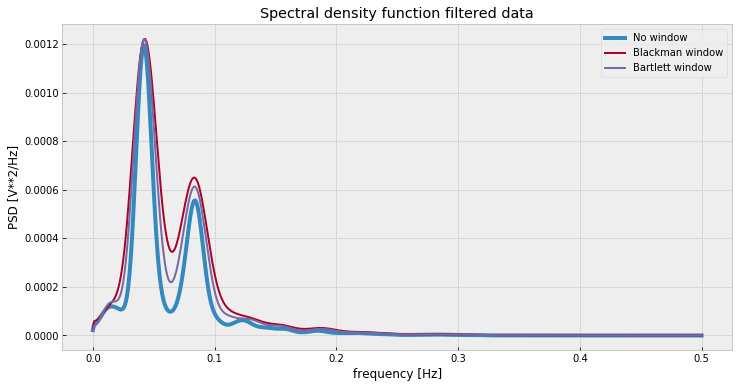

In [19]:
f1, Pxx_den1 = signal.welch(gaussian_volume_1, fs=1, scaling='spectrum', nfft = 1000, nperseg=100,)
f_window1, Pxx_den_window1 = signal.welch(gaussian_volume_1, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
f_window_bart1, Pxx_den_window_bart1 = signal.welch(gaussian_volume_1, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')

plt.plot(f1, Pxx_den1, linewidth=4, label='No window')
plt.plot(f_window1, Pxx_den_window1, label='Blackman window')
plt.plot(f_window_bart1, Pxx_den_window_bart1, label='Bartlett window')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Spectral density function filtered data')
plt.legend()
plt.show()

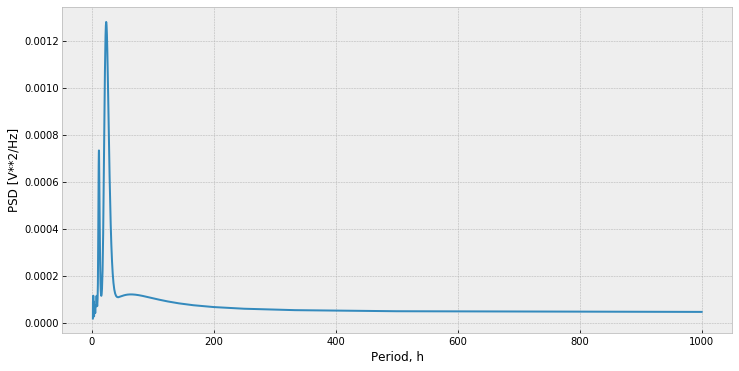

In [20]:
plt.plot(1/f, Pxx_den)
plt.xlabel('Period, h')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

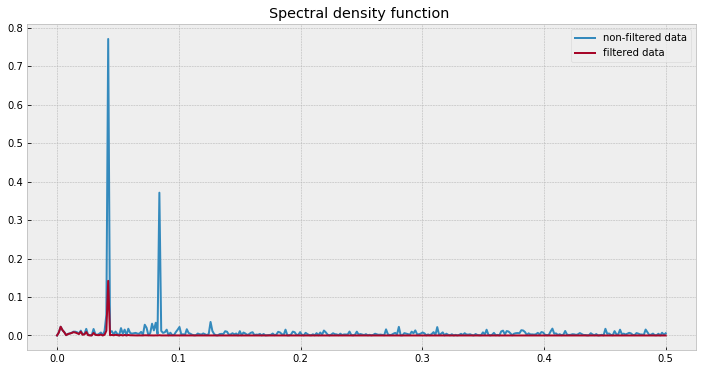

In [21]:
f1, p1 = signal.periodogram(x=initial_volume,fs=1,window=None)
f2, p2 = signal.periodogram(x=gaussian_volume_5,fs=1,window=None)


plt.plot(f1, p1, label='non-filtered data')
plt.plot(f2, p2, label='filtered data')
plt.title('Spectral density function ')
plt.legend()
plt.show()

### Step 6

Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.

1. Auto-regression model on non-filtered

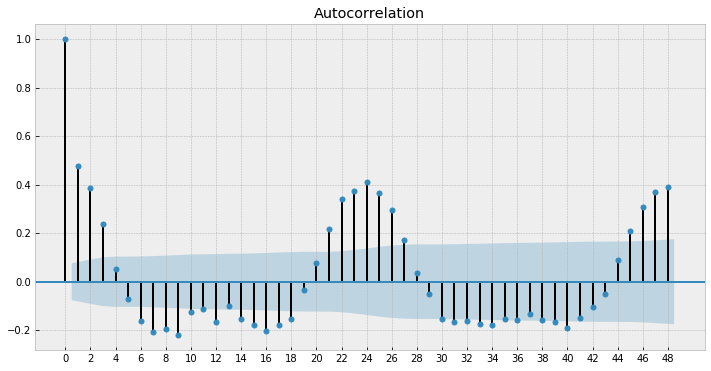

In [22]:
plot_acf(initial_volume, lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

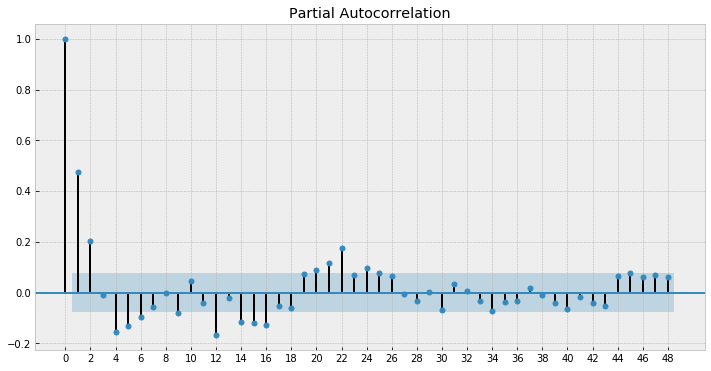

In [23]:
plot_pacf(initial_volume, lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [24]:
# q = 3
q = 3
p = 2

ARIMA(p, d, q)

In [25]:
test_size = 48
train_size = len(data)-48

In [26]:
mod = ARIMA(initial_volume[:train_size], order=(p, 0, q))
res = mod.fit()

In [27]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 volume   No. Observations:                  618
Model:                     ARMA(2, 3)   Log Likelihood                 921.653
Method:                       css-mle   S.D. of innovations              0.054
Date:                Sun, 04 Dec 2022   AIC                          -1829.306
Time:                        00:37:34   BIC                          -1798.321
Sample:                             0   HQIC                         -1817.260
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1262      0.002     52.841      0.000       0.122       0.131
ar.L1.volume     1.6836      0.048     34.942      0.000       1.589       1.778
ar.L2.volume    -0.7759      0.045    -17.227      0.000      -0.864      -0.688
ma.L1.volume    -1.3398      0.059    -22.549      0.000      -1.456      -1.223
ma.L2.volume     0.5411      0.071      7.644      0.000       0.402       0.680
ma.L3.volume    -0.1012      0.047     -2.159      0.031      -0.193      -0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0849           -0.3344j            1.1352           -0.0476
AR.2            1.0849           +0.3344j            1.1352            0.0476
MA.1            1.1927           -0.0000j            1.1927           -0.0000
MA.2            2.0760           -1.9929j            2.8777           -0.1217
MA.3            2.0760           +1.9929j            2.8777            0.1217
-----------------------------------------------------------------------------
"""

In [28]:
pred_train = res.predict(start=0, end=train_size)
pred_test = res.predict(start=train_size, end=train_size+test_size)

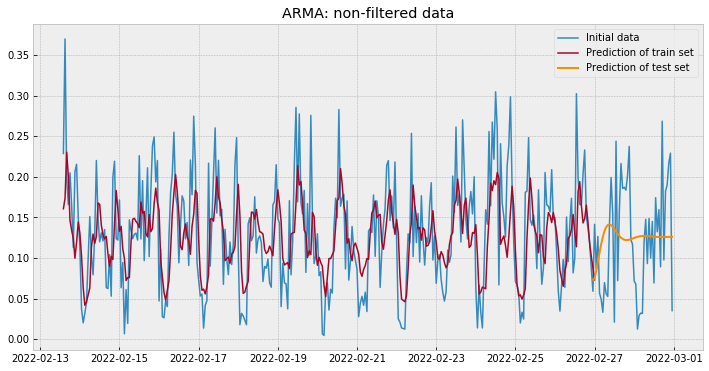

In [29]:
plt.plot(dates[300:], initial_volume.values[300:], linewidth=1.5, label='Initial data')
plt.plot(dates[300:train_size+1], pred_train.values[300:], linewidth=1.5, label='Prediction of train set')
plt.plot(dates[train_size-1 : train_size+test_size],pred_test.values, c='#FF8900', linewidth=2, label='Prediction of test set')
plt.title('ARMA: non-filtered data')
plt.legend()
plt.show()

In [30]:
r2_train = round(r2_score(initial_volume[:len(pred_train)], pred_train),3)
r2_test = round(r2_score(initial_volume[-len(pred_test):], pred_test),3)
mae_train = round(mean_absolute_error(initial_volume[:len(pred_train)], pred_train),3)
mae_test = round(mean_absolute_error(initial_volume[-len(pred_test):], pred_test),3)

print('R2 scores')
print('R2 score on train set: ', r2_train)
print('R2 score on test set: ', r2_test, '\n')
print('MAE scores')
print('MAE score on train set: ', mae_train)
print('MAE score on test set: ', mae_test)

R2 scores
R2 score on train set:  0.311
R2 score on test set:  -0.012 

MAE scores
MAE score on train set:  0.043
MAE score on test set:  0.058


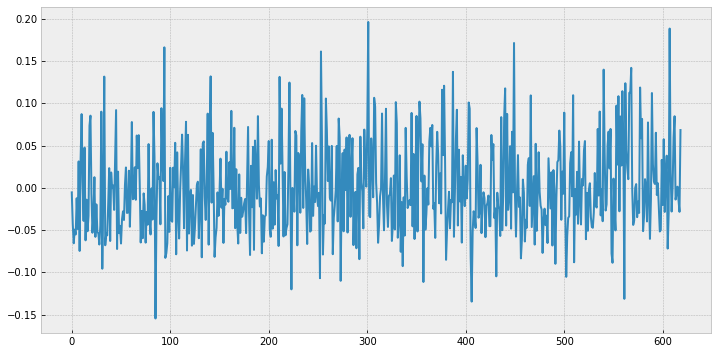

In [31]:
residuals = initial_volume[:len(pred_train)] - pred_train
plt.plot(residuals)
plt.show()

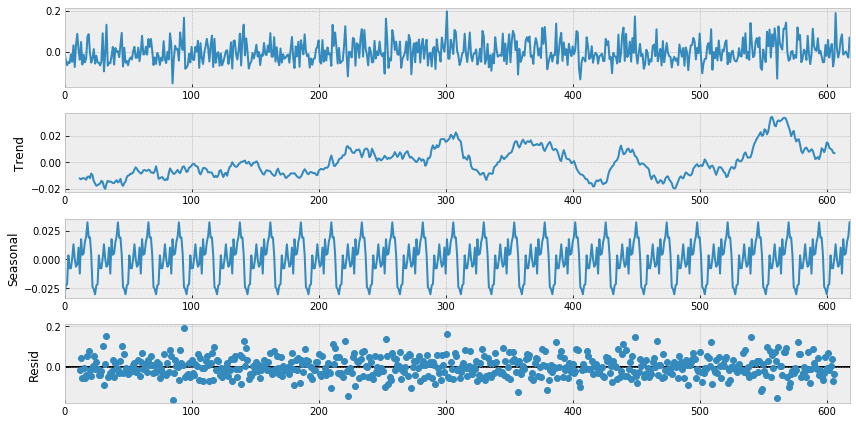

In [32]:
seasonal_decompose(residuals, period=24).plot()
plt.show()

2. Auto-regression model on filtered data

In [33]:
mod = ARIMA(gaussian_volume_1[:train_size], order=(p, 0, q))
res = mod.fit()

In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  618
Model:                     ARMA(2, 3)   Log Likelihood                1910.785
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sun, 04 Dec 2022   AIC                          -3807.570
Time:                        00:37:36   BIC                          -3776.585
Sample:                             0   HQIC                         -3795.524
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1263      0.002     52.707      0.000       0.122       0.131
ar.L1.y        1.6895      0.035     48.817      0.000       1.622       1.757
ar.L2.y       -0.7800      0.029    -26.659      0.000      -0.837      -0.723
ma.L1.y        0.5845      0.048     12.149      0.000       0.490       0.679
ma.L2.y       -0.6489      0.057    -11.473      0.000      -0.760      -0.538
ma.L3.y       -0.4450      0.046     -9.574      0.000      -0.536      -0.354
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0830           -0.3304j            1.1323           -0.0471
AR.2            1.0830           +0.3304j            1.1323            0.0471
MA.1            1.1993           -0.0000j            1.1993           -0.0000
MA.2           -1.3287           -0.3290j            1.3688           -0.4614
MA.3           -1.3287           +0.3290j            1.3688            0.4614
-----------------------------------------------------------------------------
"""

In [35]:
pred_train_ar = res.predict(start=0, end=train_size)
pred_test_ar = res.predict(start=train_size, end=train_size+test_size)

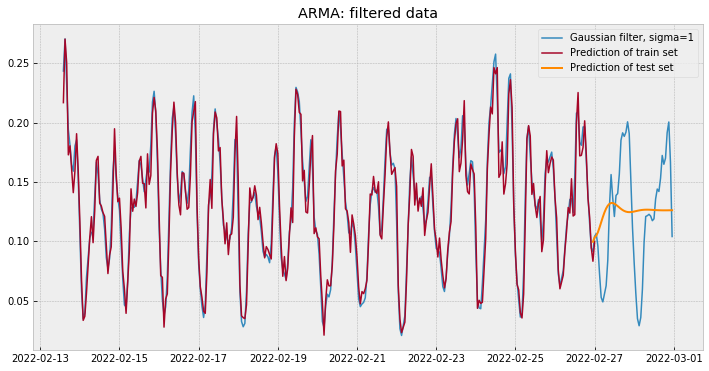

In [36]:
plt.plot(dates[300:], gaussian_volume_1[300:], linewidth=1.5, label='Gaussian filter, sigma=1')
plt.plot(dates[300:train_size+1], pred_train_ar[300:], linewidth=1.5, label='Prediction of train set')
plt.plot(dates[train_size-1 : train_size+test_size], pred_test_ar, c='#FF8900', linewidth=2, label='Prediction of test set')
plt.title('ARMA: filtered data')
plt.legend()
plt.show()

In [37]:
r2_train_filtered = round(r2_score(gaussian_volume_1[:len(pred_train)], pred_train),3)
r2_test_filtered = round(r2_score(gaussian_volume_1[-len(pred_test):], pred_test),3)
mae_train_filtered = round(mean_absolute_error(gaussian_volume_1[:len(pred_train)], pred_train),3)
mae_test_filtered = round(mean_absolute_error(initial_volume[-len(pred_test):], pred_test),3)

print('R2 scores')
print('R2 score on train set non-filtered data: ', r2_train)
print('R2 score on train set filtered data: ', r2_train_filtered)
print('R2 score on test set non-filtered data: ', r2_test)
print('R2 score on test set filtered data: ', r2_test_filtered, '\n')

print('MAE scores')
print('MAE score on train set non-filtered data: ', mae_train)
print('MAE score on train set filtered data: ', mae_train_filtered)
print('MAE score on test set non-filtered data: ', mae_test)
print('MAE score on test set filtered data: ', mae_test_filtered)

R2 scores
R2 score on train set non-filtered data:  0.311
R2 score on train set filtered data:  0.602
R2 score on test set non-filtered data:  -0.012
R2 score on test set filtered data:  -0.024 

MAE scores
MAE score on train set non-filtered data:  0.043
MAE score on train set filtered data:  0.025
MAE score on test set non-filtered data:  0.058
MAE score on test set filtered data:  0.058


### Step 7

Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model.

The results on non-filtered data are bad as in our model we didn't pay attention on seasonality.
Let's build model with seasonal components and compare quality with previous score.

3. SARIMAX

In [38]:
p = range(1, 4)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1
D = 1

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [39]:
results = []
best = 0
best_param = []
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    model = SARIMAX(data['volume'][:train_size], 
                exog= data[predictors][:train_size],
                order=(param[0], 1, param[1]), 
                seasonal_order=(param[2], 1, param[3], 12)).fit()
        
    aic = model.aic
    if best > aic:
        best = aic
        best_param = param
    results.append([param, model.aic])

In [40]:
param

(3, 2, 1, 1)

In [41]:
param = best_param
model = SARIMAX(data['volume'][:train_size], 
                exog= data[predictors][:train_size],
                order=(param[0], 1, param[1]), 
                seasonal_order=(param[2], 1, param[3], 12)).fit()

In [42]:
pred_train = model.predict(start=0, end=train_size-1, exog=data[predictors][:train_size])
pred_test = model.predict(start=train_size, end=train_size+test_size, exog=data[predictors][-test_size-1:].reset_index(drop=True))               

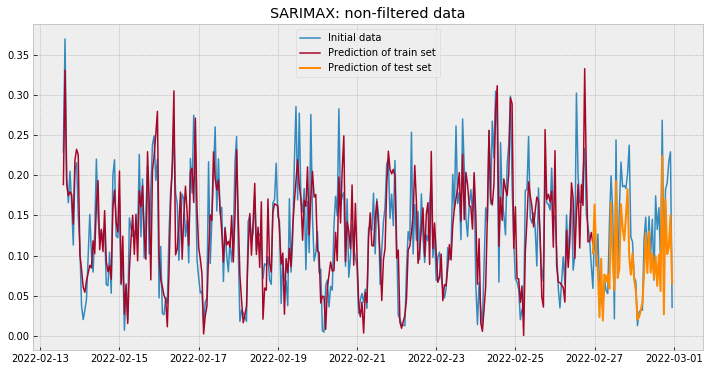

In [43]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(dates[300:], initial_volume.values[300:], linewidth=1.5, label='Initial data')
plt.plot(dates[300:train_size], pred_train.values[300:], linewidth=1.5, label='Prediction of train set')
plt.plot(dates[train_size-1 : train_size+test_size],pred_test.values, c='#FF8900', linewidth=2, label='Prediction of test set')
plt.title('SARIMAX: non-filtered data')
plt.legend()
plt.show()

In [44]:
r2_train_sarimax = round(r2_score(initial_volume.values[:train_size], pred_train.values),3)
r2_test_sarimax = round(r2_score(initial_volume.values[-test_size-1:], pred_test),3)

In [45]:
print('R2 scores')
print('R2 score on train set non-filtered data ARMA: ', r2_train)
print('R2 score on train set filtered data ARMA: ', r2_train_filtered)
print('R2 score on train set non-filtered data SARIMAX: ', r2_train_sarimax,'\n')


print('R2 score on test set non-filtered data: ', r2_test)
print('R2 score on test set filtered data: ', r2_test_filtered, )
print('R2 score on test set non-filtered data SARIMAX: ', r2_test_sarimax)

R2 scores
R2 score on train set non-filtered data ARMA:  0.311
R2 score on train set filtered data ARMA:  0.602
R2 score on train set non-filtered data SARIMAX:  0.46 

R2 score on test set non-filtered data:  -0.012
R2 score on test set filtered data:  -0.024
R2 score on test set non-filtered data SARIMAX:  0.475


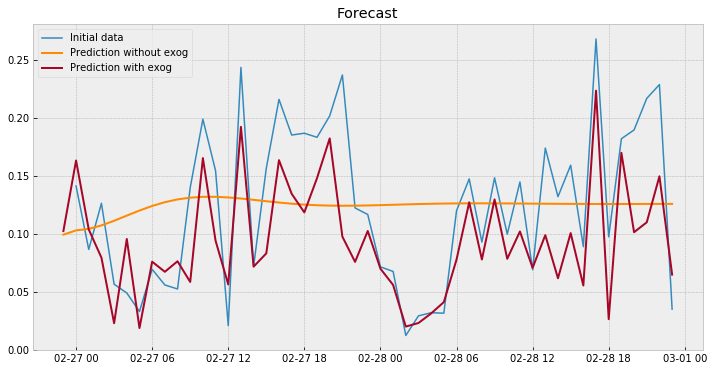

In [46]:
plt.plot(dates[-test_size :], initial_volume.values[-test_size:], linewidth=1.5, label='Initial data')
plt.plot(dates[train_size-1 : train_size+test_size], pred_test_ar, linewidth=2, c='#FF8900', label='Prediction without exog')
plt.plot(dates[train_size-1 : train_size+test_size], pred_test.values, linewidth=2, label='Prediction with exog')
plt.title('Forecast')
plt.legend()
plt.show()

In [47]:
print('R2 scores')
print('R2 score on test set ARMA: ', r2_test)
print('R2 score on test set SARIMAX: ', r2_test_sarimax)

R2 scores
R2 score on test set ARMA:  -0.012
R2 score on test set SARIMAX:  0.475
